In [7]:
!pip install -q sklearn
!pip install -q matplotlib

In [1]:
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import os
import io
from online_vectorizers import OnlineTfidfVectorizer
import scipy
import csv
import matplotlib.pyplot as plt
import pickle

In [9]:
base_dir = 'dataset_parsed'

#primo file
filename = "00_total_no_stopwords.csv"
fname = os.path.join(base_dir, filename)
df = pd.read_csv(fname)

#classe custom di libreria che estende quello base di scikit-learn. Aggiunge il partial-refit
vectorizer = OnlineTfidfVectorizer()

#necessario per inizializzare il vocabolario del vectorizer per poi fare partial fitting
#attualmente refitta due volte sul primo documento ma dovrebbe essere idempotente, alla peggio si aggiunge una guardia nel for
vectorizer.fit(df["text"].apply(lambda x: np.str_(x)))


#fittiamo il dizionario del vectorizer con tutte le parole in tutti i file. Necessario un partial refit per non mettere
#tutti i 200 file in RAM. Prima passata.
def fit_vectorizer(corpus_path):
    corpus_path, dirs, files = next(os.walk(corpus_path))
    if "dataset_parsed" in dirs:
        corpus_path = os.sep.join([corpus_path,"dataset_parsed"])
    
    for f in files:
        print(f)
        try:
            data_path = os.sep.join([base_dir, f])
            document = pd.read_csv(data_path)
            vectorizer.partial_refit(document["text"].apply(lambda x: np.str_(x)))
            print("La dimensione del vocabolario è:" + str(len(vectorizer.vocabulary_)))
        except Exception as e:
            print(e)

c:\users\gabriele\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass input=content, encoding=utf-8, decode_error=strict, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=(?u)\b\w\w+\b, ngram_range=(1, 1), analyzer=word, max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'> as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [10]:
fit_vectorizer(base_dir)
print("La dimensione del vocabolario è:" + str(len(vectorizer.vocabulary_)))
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

00_total_no_stopwords.csv
La dimensione del vocabolario è:227118
01_total_no_stopwords.csv
La dimensione del vocabolario è:420261
02_total_no_stopwords.csv
La dimensione del vocabolario è:495523
03_total_no_stopwords.csv
La dimensione del vocabolario è:601801
04_total_no_stopwords.csv
La dimensione del vocabolario è:733443
05_total_no_stopwords.csv
La dimensione del vocabolario è:794358
06_total_no_stopwords.csv
La dimensione del vocabolario è:891633
07_total_no_stopwords.csv
La dimensione del vocabolario è:976285
08_total_no_stopwords.csv
La dimensione del vocabolario è:1036152
09_total_no_stopwords.csv
La dimensione del vocabolario è:1160432
0a_total_no_stopwords.csv
La dimensione del vocabolario è:1199077
0b_total_no_stopwords.csv
La dimensione del vocabolario è:1245032
0c_total_no_stopwords.csv
La dimensione del vocabolario è:1282368
0d_total_no_stopwords.csv
La dimensione del vocabolario è:1314025
0e_total_no_stopwords.csv
La dimensione del vocabolario è:1361774
0f_total_no_stopwo

La dimensione del vocabolario è:9525172
7d_total_no_stopwords.csv
La dimensione del vocabolario è:9547483
7e_total_no_stopwords.csv
La dimensione del vocabolario è:9563838
7f_total_no_stopwords.csv
La dimensione del vocabolario è:9574249
80_total_no_stopwords.csv
La dimensione del vocabolario è:9590993
81_total_no_stopwords.csv
La dimensione del vocabolario è:9636401
82_total_no_stopwords.csv
La dimensione del vocabolario è:9657412
83_total_no_stopwords.csv
La dimensione del vocabolario è:10077725
84_total_no_stopwords.csv
La dimensione del vocabolario è:10085790
85_total_no_stopwords.csv
La dimensione del vocabolario è:10107911
86_total_no_stopwords.csv
La dimensione del vocabolario è:10137858
87_total_no_stopwords.csv
La dimensione del vocabolario è:10223058
88_total_no_stopwords.csv
La dimensione del vocabolario è:10232942
89_total_no_stopwords.csv
La dimensione del vocabolario è:10258286
8a_total_no_stopwords.csv
La dimensione del vocabolario è:10268568
8b_total_no_stopwords.csv
La

La dimensione del vocabolario è:13191542
f8_total_no_stopwords.csv
La dimensione del vocabolario è:13210809
f9_total_no_stopwords.csv
La dimensione del vocabolario è:13254189
fa_total_no_stopwords.csv
La dimensione del vocabolario è:13515391
fb_total_no_stopwords.csv
La dimensione del vocabolario è:16526623
fc_total_no_stopwords.csv
La dimensione del vocabolario è:16552042
fd_total_no_stopwords.csv
La dimensione del vocabolario è:16588995
fe_total_no_stopwords.csv
La dimensione del vocabolario è:16598568
ff_total_no_stopwords.csv
La dimensione del vocabolario è:16612707
La dimensione del vocabolario è:16612707


In [11]:
#creiamo la matrice delle features andando a trasformare ogni file tramite il vectorizer. Necessaria questa seconda passata
#in quanto non è possibile farlo in parallelo a causa del vectorizer che è pronto solo alla fine della prima passata.

#Qua non è necessario un partial refit ma è necessario concatenare ogni matrice di ogni documento, in modo da crearne una totale
#La funzione per "concatenare" matrici (orizzontalmente come serve a noi in questo caso) è vstack. Utilizzo matrix come
#accumulatore e lo restituisco alla fine
def transform(corpus_path):
    corpus_path, dirs, files = next(os.walk(corpus_path))
    if "dataset_parsed" in dirs:
        corpus_path = os.sep.join([corpus_path,"dataset_parsed"])
    matrix = scipy.sparse.csr_matrix((0, len(vectorizer.vocabulary_)), dtype=None)
    for f in files:
        print(f)
        try:
            data_path = os.sep.join([base_dir, f])
            document = pd.read_csv(data_path)
            partial_matrix = vectorizer.transform(document["text"].apply(lambda x: np.str_(x)))
            print("La shape della matrice del documento attuale è: " + str(partial_matrix.shape))
            print("La shape della matrice totale prima è: " + str(matrix.shape))
            matrix = scipy.sparse.vstack([matrix,partial_matrix])
            print("La shape della matrice totale dopo l'unione è: " + str(matrix.shape))
        except Exception as e:
            print(e)
    return matrix

In [12]:
features_matrix = transform(base_dir)
print("La dimensione della matrice di features è:" + str(features_matrix.shape))
scipy.sparse.save_npz('features_matrix_on_documents', features_matrix)

00_total_no_stopwords.csv
La shape della matrice del documento attuale è: (10488, 16612707)
La shape della matrice totale prima è: (0, 16612707)
La shape della matrice totale dopo l'unione è: (10488, 16612707)
01_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12837, 16612707)
La shape della matrice totale prima è: (10488, 16612707)
La shape della matrice totale dopo l'unione è: (23325, 16612707)
02_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12878, 16612707)
La shape della matrice totale prima è: (23325, 16612707)
La shape della matrice totale dopo l'unione è: (36203, 16612707)
03_total_no_stopwords.csv
La shape della matrice del documento attuale è: (13119, 16612707)
La shape della matrice totale prima è: (36203, 16612707)
La shape della matrice totale dopo l'unione è: (49322, 16612707)
04_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12661, 16612707)
La shape della matrice totale prima è: (49322, 16612707)

La shape della matrice del documento attuale è: (12687, 16612707)
La shape della matrice totale prima è: (482463, 16612707)
La shape della matrice totale dopo l'unione è: (495150, 16612707)
27_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12610, 16612707)
La shape della matrice totale prima è: (495150, 16612707)
La shape della matrice totale dopo l'unione è: (507760, 16612707)
28_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12663, 16612707)
La shape della matrice totale prima è: (507760, 16612707)
La shape della matrice totale dopo l'unione è: (520423, 16612707)
29_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12725, 16612707)
La shape della matrice totale prima è: (520423, 16612707)
La shape della matrice totale dopo l'unione è: (533148, 16612707)
2a_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12760, 16612707)
La shape della matrice totale prima è: (533148, 16612707)
La shape del

La shape della matrice del documento attuale è: (12499, 16612707)
La shape della matrice totale prima è: (966820, 16612707)
La shape della matrice totale dopo l'unione è: (979319, 16612707)
4d_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12748, 16612707)
La shape della matrice totale prima è: (979319, 16612707)
La shape della matrice totale dopo l'unione è: (992067, 16612707)
4e_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12782, 16612707)
La shape della matrice totale prima è: (992067, 16612707)
La shape della matrice totale dopo l'unione è: (1004849, 16612707)
4f_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12749, 16612707)
La shape della matrice totale prima è: (1004849, 16612707)
La shape della matrice totale dopo l'unione è: (1017598, 16612707)
50_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12833, 16612707)
La shape della matrice totale prima è: (1017598, 16612707)
La shape

La shape della matrice del documento attuale è: (12646, 16612707)
La shape della matrice totale prima è: (1451083, 16612707)
La shape della matrice totale dopo l'unione è: (1463729, 16612707)
73_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12778, 16612707)
La shape della matrice totale prima è: (1463729, 16612707)
La shape della matrice totale dopo l'unione è: (1476507, 16612707)
74_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12909, 16612707)
La shape della matrice totale prima è: (1476507, 16612707)
La shape della matrice totale dopo l'unione è: (1489416, 16612707)
75_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12686, 16612707)
La shape della matrice totale prima è: (1489416, 16612707)
La shape della matrice totale dopo l'unione è: (1502102, 16612707)
76_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12749, 16612707)
La shape della matrice totale prima è: (1502102, 16612707)
La 

La shape della matrice del documento attuale è: (12940, 16612707)
La shape della matrice totale prima è: (1935284, 16612707)
La shape della matrice totale dopo l'unione è: (1948224, 16612707)
99_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12801, 16612707)
La shape della matrice totale prima è: (1948224, 16612707)
La shape della matrice totale dopo l'unione è: (1961025, 16612707)
9a_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12727, 16612707)
La shape della matrice totale prima è: (1961025, 16612707)
La shape della matrice totale dopo l'unione è: (1973752, 16612707)
9b_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12580, 16612707)
La shape della matrice totale prima è: (1973752, 16612707)
La shape della matrice totale dopo l'unione è: (1986332, 16612707)
9c_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12542, 16612707)
La shape della matrice totale prima è: (1986332, 16612707)
La 

La shape della matrice del documento attuale è: (12677, 16612707)
La shape della matrice totale prima è: (2420286, 16612707)
La shape della matrice totale dopo l'unione è: (2432963, 16612707)
bf_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12616, 16612707)
La shape della matrice totale prima è: (2432963, 16612707)
La shape della matrice totale dopo l'unione è: (2445579, 16612707)
c0_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12549, 16612707)
La shape della matrice totale prima è: (2445579, 16612707)
La shape della matrice totale dopo l'unione è: (2458128, 16612707)
c1_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12666, 16612707)
La shape della matrice totale prima è: (2458128, 16612707)
La shape della matrice totale dopo l'unione è: (2470794, 16612707)
c2_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12734, 16612707)
La shape della matrice totale prima è: (2470794, 16612707)
La 

La shape della matrice del documento attuale è: (12872, 16612707)
La shape della matrice totale prima è: (2905135, 16612707)
La shape della matrice totale dopo l'unione è: (2918007, 16612707)
e5_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12841, 16612707)
La shape della matrice totale prima è: (2918007, 16612707)
La shape della matrice totale dopo l'unione è: (2930848, 16612707)
e6_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12688, 16612707)
La shape della matrice totale prima è: (2930848, 16612707)
La shape della matrice totale dopo l'unione è: (2943536, 16612707)
e7_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12780, 16612707)
La shape della matrice totale prima è: (2943536, 16612707)
La shape della matrice totale dopo l'unione è: (2956316, 16612707)
e8_total_no_stopwords.csv
La shape della matrice del documento attuale è: (12546, 16612707)
La shape della matrice totale prima è: (2956316, 16612707)
La 

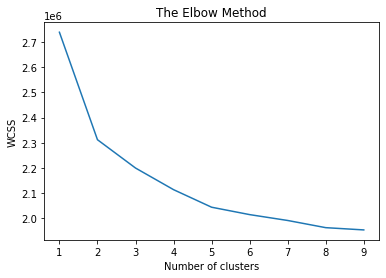

In [13]:
#Calcolo e plot dell'elbow method per capire il numero giusto di clusters. In ogni caso io farei con 5 ma facciamolo comunque.
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
  kmeans.fit(features_matrix)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [4]:
def load_matrix(filename='features_matrix_on_documents.npz'):
    return scipy.sparse.load_npz(filename)
features_matrix = load_matrix()

In [5]:
#DA SCOMMENTARE E RUNNARE DOPO AVER RUNNATO AL CELLA PRECEDENTE

true_k = 8 #da scegliere dopo aver runnato la cella precedente in base al grafico
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(features_matrix)
pickle.dump(model, open(f"kmeans_{true_k}.pkl", "wb"))


In [6]:
#DA RUNNARE PER FARE PREDICTIONS, SCOMMENTARE LE PRIME DUE RIGHE SE SI VUOLE CARICARE IL MODELLO E IL VECTORIZER

model = pickle.load(open(f"kmeans_{true_k}.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer.pickle", "rb"))

#per stampare feature più utili dei centroidi/clusters
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
true_k = len(order_centroids)
terms = vectorizer.get_feature_names()
s = ""
for i in range(true_k):
 s += f"Cluster {i}:\n"
 for ind in order_centroids[i, :20]:
  s += f"{terms[ind]}\n"

with open(f"clusters_{true_k}.txt", "w") as f:
    f.write(s)
    



#PER FARE PREDICTIONS SUI DOCUMENTI NUOVI, INSERIRE IL DOCUMENTO ALLA RIGA 3
#print("\n")
#print("Prediction")
#prova = vectorizer.transform(#inserire un documento da testare)
#predicted = model.predict(prova)
#print(predicted)

In [7]:
print(s)

Cluster 0:
cftoken
cfid
author_page
cfm
id
77457483
591235341
765090987
75498192
71109929
765085604
594905241
10064889
592210092
73302323
31726020
594932833
68381372
765146704
20118523
Cluster 1:
software
without
copyright
copies
permission
shall
including
copy
notice
mit
use
deal
furnished
dealings
merge
noninfringement
persons
obtaining
portions
person
Cluster 2:
com
license
software
copyright
gmail
http
org
author
public
use
version
https
package
class
www
name
github
source
notice
code
Cluster 3:
gnu
general
public
license
program
debian
version
gpl
foundation
software
see
free
org
redistribute
terms
later
licenses
hope
useful
published
Cluster 4:
work
program
license
terms
source
may
works
covered
derivative
code
patent
contributor
version
public
general
form
object
software
it
licensor
Cluster 5:
contributors
redistributions
copyright
binary
to
disclaimer
must
list
source
following
including
conditions
provided
use
software
procurement
substitute
disclaimed
goods
interruption
Clu

In [8]:
!pip install -q python-telegram-bot
from telegram import Bot
bot = Bot(token="627493222:AAE8dqAHnrx9JJ3AGxDwb-x2eiJqoXVBM8o")
bot.send_message(text="Finito di salvare dataset completo", chat_id="141928344")

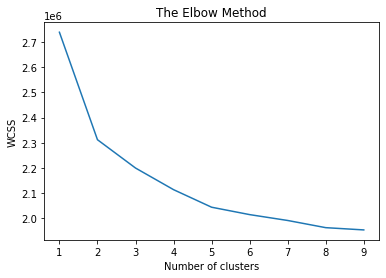

In [27]:
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow_method.png')
plt.show()